


# Surface Event Analysis

This is a modified version of the surface-event location+directivity analysis that Francesca Skene ( fskene@uw.edu), originally created by her in 7/22/22, who started as an undergraduate student at UW. This is marine denolle's version. It includes:
* Waveform download for each event on each volcano given the PNSN pick times of "su" events.
* Data pre-processing to trim the data within 2-12 Hz and remove outliers.
* phase picking using transfer-learned model (Ni et al, 2023)
* event location using 1D grid search
* directivity measurements (velocity and direction) using Doppler effects.
* gathering of the data into a CSV data frame.

Updated 08/09/2023
Marine Denolle
(mdenolle@uw.edu)

Import Modules

In [3]:
# import sys
# sys.path.append('/data/wsd01/pnwstore/')
import matplotlib.pyplot as plt
# from matplotlib.pyplot import Figure
import numpy as np
import pandas as pd
import obspy
from obspy.core import UTCDateTime
from obspy.clients.fdsn.client import Client
# import obspy.realtime as rt
# from obspy.geodetics import *
# from obspy.signal.cross_correlation import *
# from obspy.signal.trigger import classic_sta_lta
# from obspy.core.utcdatetime import UTCDateTime
# import requests
# import glob
# from pnwstore.mseed import WaveformClient
# from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
from scipy import optimize
from scipy.optimize import curve_fit
from geopy import distance
from datetime import datetime
import rasterio as rio
import torch
# from rasterio.plot import show
# from rasterio.merge import merge
# import richdem as rd
# from pathlib import Path
# from pyproj import Proj,transform,Geod
# import os 
# from scipy.interpolate import RectBivariateSpline
plt.rcParams.update({'font.size': 10})


import seisbench.models as sbm
device = torch.device("cpu")

from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.ensemble_coherence import ensemble_semblance 
from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
from ELEP.elep import mbf, mbf_utils
from ELEP.elep import trigger_func

from ELEP.elep.mbf_utils import make_LogFq, make_LinFq, rec_filter_coeff, create_obspy_trace
from ELEP.elep.mbf import MB_filter as MBF

Parameters

In [4]:
# define clients to download the station data
# client = WaveformClient() # we ignore PNWdatastore for now
client2 = Client('IRIS')

t_before = 120 #number of seconds before pick time
t_after = 120 #number of seconds after pick time
t_before_raw = 1200 #number of seconds before pick time before removing instrumental response
t_after_raw = 1200 #number of seconds after pick time before removing instrumental response
fs = 40 #sampling rate that all waveforms are resampled to
window = 160 #window length of the signal (this will help with phase picking with EqT next). 
# Use 150 seconds @ 40 Hz gives 6001 points. but seisbench asks to pad with 5s before and after.
pr = 98 #percentile
thr = 5 #SNR threshold
station_distance_threshold = 25
pi = np.pi
v_s = 1000 #shear wave velocity at the surface

# range of dates that we are looking at
t_beginning = UTCDateTime(2001,1,1,0,0,0) 
t_end = UTCDateTime(2023,8,2,23,59)

smooth_length = 5 # constant for smoothing the waveform envelopes
low_cut = 1 #low frequency threshold
high_cut = 12 #high frequency threshold
az_thr = 1000 #threshold of distance in meters from source location
step = 100 #step every 100 m
t_step = 1 #step every second
ratio = 5.6915196 #used to define the grid 
colors = list(plt.cm.tab10(np.arange(10)))*3
radius = 6371e3 # radius of the earth

## Download eqT models

In [5]:
import os
os.makedirs("/Users/marinedenolle/.seisbench/models/v3/eqtransformer",exist_ok=True)


In [6]:
!wget https://github.com/congcy/ELEP/raw/main/docs/tutorials/data/pnw.pt.v1 -O ~/.seisbench/models/v3/eqtransformer/pnw.pt.v1
!wget https://github.com/congcy/ELEP/raw/main/docs/tutorials/data/pnw.json.v1 -O ~/.seisbench/models/v3/eqtransformer/pnw.json.v1

--2023-08-14 16:36:20--  https://github.com/congcy/ELEP/raw/main/docs/tutorials/data/pnw.pt.v1
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/congcy/ELEP/main/docs/tutorials/data/pnw.pt.v1 [following]
--2023-08-14 16:36:20--  https://raw.githubusercontent.com/congcy/ELEP/main/docs/tutorials/data/pnw.pt.v1
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1592020 (1.5M) [application/octet-stream]
Saving to: ‘/Users/marinedenolle/.seisbench/models/v3/eqtransformer/pnw.pt.v1’

/Users/marinedenoll 100%[===================>]   1.52M  2.57MB/s    in 0.6s    

2023-08-14 16:36:21 (2.57 MB/s) - ‘/Use

In [7]:
# download models
eqt = sbm.EQTransformer.from_pretrained('pnw')
pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

eqt.to(device);
pn_scedc_model.to(device);

## Define Functions

In [8]:
#define a function that calculates picktimes at each station
def pick_time(time, ref_env, data_env_dict, st, t_diff, t_before, fs):
    pick_times,offsets, starttimes = [],[],[]
    for i,key in enumerate(data_env_dict):
        starttimes.append(st[i].stats.starttime)
        xcor = correlate(data_env_dict[key],ref_env,int(50*fs))
        index = np.argmax(xcor)
        cc = round(xcor[index],9) #correlation coefficient
        shift = 50*fs-index #how much it is shifted from the reference envelope
        offset_time = time - shift/fs
        p = time - shift/fs  # p is the new phase pick for each station
        pick_times.append(p+t_diff[key])
        offsets.append(offset_time + t_diff[key])
    return pick_times, offsets, starttimes
    
def shift(pick_times, offsets, starttimes, t_diff):
    shifts, vals =[],[]
    for i,ii in enumerate(t_diff):
        t_shift = offsets[i]-min(offsets)
        vals.append((-1*t_diff[ii])+t_shift)
        shifts.append(t_shift)
        #plt.vlines(val, ymin = iplot*1.5-.5, ymax = iplot*1.5+.5, color = colors[i])
    return shifts, vals

# define functon that resamples the data
def resample(st, fs):
    for i in st:
        i.detrend(type='demean')
        i.taper(0.05)
        i.resample(fs)   
    return st

# define function to calculate number of surface events per month
def events_per_month(starttimes, events):
    num_events = {}
    for year in range (2001, 2021):
        for month in range (1, 13):
            Nevt = []
            period = str(year)+"_"+str(month)
            t0 = UTCDateTime(year, month, 1)
            t1 = t0+3600*24*30
            for i in range(0, len(starttimes)):
                if t0<starttimes[i]<t1:
                    Nevt.append(events[i])
            if len(Nevt) != 0:
                num_events[period]=len(Nevt)
            if len(Nevt) == 0:
                num_events[period] = 0

    periods = list(num_events.keys())
    num_of_events = list(num_events.values())
    return periods, num_of_events

# define function to fit data to
def test_func(theta, a,theta0, c):
    return a * np.cos(theta-theta0)+c

# define a function to make plots of weighted data
def weight_data(x_data,y_data,weight,test_func,v_s,stas):    
    #weighting the data
    tempx, tempy = [],[]
    for i,ii in enumerate(x_data):
        tempx.append([])
        tempx[i].append([ii for l in range(0,weight[i])])
        tempy.append([])
        tempy[i].append([y_data[i] for l in range(0,weight[i])])   
    weighted_x = sum(sum(tempx, []),[])
    weighted_y = sum(sum(tempy, []),[])
   
    #optimizing parameters to fit weighted data to test_function
    params, params_covariance = optimize.curve_fit(test_func, np.deg2rad(weighted_x), weighted_y, p0=None)
    d = test_func(np.deg2rad(x_points), params[0], params[1], params[2])
    if params[0]<0:
        direction = params[1]+pi 
    else:
        direction = params[1]   
    fmax = max(d)
    fmin = min(d)
    v = v_s*((fmax-fmin)/(fmax+fmin))
    return v, direction, d

# define function to predict synthetic arrival times
def travel_time(t0, x, y, vs, sta_x, sta_y):
    dist = np.sqrt((sta_x - x)**2 + (sta_y - y)**2)
    tt = t0 + dist/vs
    return tt

# define function to compute residual sum of squares
def error(synth_arrivals,arrivals, weight):
    res = (arrivals - synth_arrivals)* weight 
    res_sqr = res**2
    mse = np.mean(res_sqr)
    rmse = np.sqrt(mse)
    return rmse

# define function to iterate through grid and calculate travel time residuals
def gridsearch(t0,x_vect,y_vect,sta_x,sta_y,vs,arrivals, weight):
    rss_mat = np.zeros((len(t0),len(x_vect),len(y_vect)))
    rss_mat[:,:,:] = np.nan
    for i in range(len(t0)):
        for j in range(len(x_vect)):
            for k in range(len(y_vect)):
                synth_arrivals = []
                for h in range(len(sta_x)):
                    tt = travel_time(t0[i],x_vect[j],y_vect[k],vs,sta_x[h],sta_y[h])
                    synth_arrivals.append(tt)
                rss = error(np.array(synth_arrivals),np.array(arrivals), np.array(weight))
                rss_mat[i,j,k] = rss
    return rss_mat

# define function to find lower-left corner of grid and grid size based on height of volcano
def start_latlon(elevation, ratio, center_lat, center_lon):
    side_length = elevation * ratio
    l = side_length/2
    hypotenuse = l*np.sqrt(2)
    d = distance.geodesic(meters = hypotenuse)
    start_lat = d.destination(point=[center_lat,center_lon], bearing=225)[0]
    start_lon = d.destination(point=[center_lat,center_lon], bearing=225)[1]
    return start_lat, start_lon, side_length

# define function to convert the location index into latitude and longitude
def location(x_dist, y_dist, start_lat, start_lon):
    bearing = 90-np.rad2deg(np.arctan(y_dist/x_dist))
    dist = np.sqrt((x_dist)**2 + (y_dist)**2)
    d = distance.geodesic(meters = dist)
    loc_lat = d.destination(point=[start_lat,start_lon], bearing=bearing)[0]
    loc_lon = d.destination(point=[start_lat,start_lon], bearing=bearing)[1]
    return loc_lat, loc_lon, d

# define function to find diameter in meters of the error on the location
def error_diameter(new_array):
    min_idx = np.min(new_array[:,1])
    max_idx = np.max(new_array[:,1])
    difference = max_idx-min_idx
    diameter_m = difference*1000
    return diameter_m 

##  Import and organize metadata

### 1. Volcano Data (network and station, labeled with volcano name)

In [9]:
#this data includes all stations within 50km of each volcano and the lat, lon, elev of each station
df = pd.read_csv('../data/station/Volcano_Metadata_50km.csv')
df_xd = pd.read_csv('../data/station/XD_Metadata_50km.csv')

In [10]:
# center latitude, center longitude, elevation(m), left_trim, right_trim, bottom_trim, top_trim 
volc_lat_lon = {}
volc_lat_lon['Mt_Rainier'] = [46.8528857, -121.7603744, 4392.5, 10000, 3000, 15000, 7000]
volc_lat_lon['Mt_Adams'] = [46.202621, -121.4906384, 3743.2, 5000, 3000, 4000, 2000]
volc_lat_lon['Mt_Baker'] = [48.7773426,  -121.8132008, 3287.6, 0, 0, 0, 2000]
# change the lat and lon of mt st helens to the middle of the dome instead of the highest point
volc_lat_lon['Mt_St_Helens'] =[46.200472222222224,-122.18883611111112,2549, 10000, 10000, 17000, 15000] #[46.1912, -122.1944, 2549]
volc_lat_lon['Glacier_Peak'] = [48.1112273, -121.1139922, 3213, 14000, 10000, 8000, 10000]
volc_lat_lon['Mt_Hood']=[45.373221, -121.696509, 3428.7, 18000, 50000, 35000, 65000]

In [11]:
#Find the lower left corner and grid size based on volcano elevation
# [start_lat = lower_left latitude of gridsearch square, start lon = lower left longitude of gridsearhc square, side length of grid search square]
volc_grid = {}
for volc in volc_lat_lon:
    elevation = volc_lat_lon[volc][2]
    center_lat = volc_lat_lon[volc][0]
    center_lon = volc_lat_lon[volc][1]
    start_lat, start_lon, side_length = start_latlon(elevation, ratio, center_lat, center_lon)
    volc_grid[volc] = [start_lat, start_lon, side_length]

In [13]:
#DEM data 
dem_data_dict = {}
for name in volc_lat_lon:
    if volc_lat_lon[name][0]>46:
        dem = rio.open('../data/geospatial/'+str(name)+'/'+str(name)+'.tif') #washington volcanoes
        dem_array = dem.read(1).astype('float64')
        dem_array[dem_array == -32767] = np.nan #gets rid of edge effects
        crs = dem.crs
    else:
        dem = rio.open('../data/geospatial/'+str(name)+'/_w001001.adf') #oregon volcanoes
        dem_array = dem.read(1).astype('float64')
        dem_array[dem_array == -3.4028234663852886e+38] = np.nan #gets rid of edge effects
        crs = dem.crs
#     volc = rd.rdarray(dem_array, no_data=-9999)
#     slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
#     aspect = rd.TerrainAttribute(volc, attrib = 'aspect')
#     dem_data_dict[name] = {'data':dem_array, 'elevation':volc, 'slope':slope, 'aspect':aspect}
    dem_data_dict[name]={'data':dem_array, 'crs':crs, 'left':dem.bounds[0], 'right':dem.bounds[2], 'bottom':dem.bounds[1], 'top':dem.bounds[3]}

RasterioIOError: ../data/geospatial/Mt_Hood/_w001001.adf: No such file or directory

In [14]:
#DEM data 
r_dem_data_dict = {}
name = 'Mt_Rainier'
if volc_lat_lon[name][0]>46:
    dem = rio.open('../data/geospatial/'+str(name)+'/'+str(name)+'1.tif') #washington volcanoes
    dem_array = dem.read(1).astype('float64')
    dem_array[dem_array == -32767] = np.nan #gets rid of edge effects
    crs = dem.crs

r_dem_data_dict[name]={'data':dem_array, 'crs':crs, 'left':dem.bounds[0], 'right':dem.bounds[2], 'bottom':dem.bounds[1], 'top':dem.bounds[3]}

In [15]:
lat_lon_dict = {}
lat_lon_dict['Mt_Rainier']={'tick_lons':[-121.65, -121.7, -121.75, -121.8, -121.85],
                            'tick_lats':[46.75,46.8,46.85,46.9,46.95]}
lat_lon_dict['Mt_St_Helens']={'tick_lons':[-122.10,-122.15,-122.2,-122.25],
                              'tick_lats':[46.16, 46.18, 46.20, 46.22]}
lat_lon_dict['Mt_Adams']={'tick_lons':[-121.6, -121.55, -121.5, -121.45, -121.4],
                          'tick_lats':[46.16, 46.18, 46.20, 46.22]}
lat_lon_dict['Mt_Baker']={'tick_lons':[ -121.7, -121.75, -121.80, -121.85, -121.90, -121.95],
                          'tick_lats':[48.71, 48.74, 48.77, 48.80, 48.83, 48.86]}
lat_lon_dict['Mt_Hood']={'tick_lons':[-121.58, -121.62, -121.66, -121.70, -121.74],
                         'tick_lats':[45.3, 45.33, 45.36, 45.39, 45.42]}
lat_lon_dict['Glacier_Peak']={'tick_lons':[ -121.07, -121.09, -121.11, -121.13, -121.15],
                              'tick_lats':[48.08, 48.10, 48.12, 48.14, 48.16]}
lat_lon_dict['Newberry']={'tick_lons':[-121.11, -121.15, -121.19, -121.23, -121.27, -121.31, -121.34],
                          'tick_lats':[43.64, 43.67, 43.70, 43.73, 43.76, 43.79, 43.82]}
lat_lon_dict['Crater_Lake']={'tick_lons':[ -121.98, -122.06, -122.14, -122.22, -122.30],
                             'tick_lats':[42.80, 42.85, 42.90, 42.95, 43.00]}

### 3. Surface Event Data from PNSN

Read files straight from PNSN data base. Extract station and network code, phase pick time (seen as start_time). this should be converted to pick_time0.

In [16]:
f1 = pd.read_csv("../data/events/su_picks.txt",sep="|")
f1.head()
print(f1.keys())

Index(['date', 'net', 'sta', 'location', 'seedchan', 'iphase', 'quality',
       'orid', 'etype', 'evid'],
      dtype='object')


In [17]:
# clean up the spaces in the file
format='%Y/%m/%d %H:%M:%S'
test=f1["date"].values.tolist()
start_time_temp = [  datetime.strptime(x.strip(),'%Y/%m/%d %H:%M:%S') for x in f1["date"].values.tolist()]
# # Ignore events prior to t_beginning
ik=np.where(np.array(start_time_temp)>datetime(2001,1,1))[0][0]

# select only net, sta, evid, startime for event past the start date.

start_time = start_time_temp[ik:]
net=[ x.strip() for x in f1["net"].values.tolist()][ik:]
sta=[ x.strip() for x in f1["sta"].values.tolist()][ik:]
evt_id=[ x for x in f1["orid"].values.tolist()][ik:]
all_stas=set(sta)

Below, Francesca had removed stations from the CN networks, and also excluded

## Calculating directivity and velocity of events

In [18]:
evt_data = pd.DataFrame(columns = ['event_ID','location_latitude','location_longitude','location_uncertainty(m)',
                                   'origin_time','direction(degrees)', 
                                   'direction_sharpness(degrees)','direction_snr(degrees)','duration(sec)',
                                   'params_std_deviation', 'velocity(m/s)','number_of_stations'])

sta_freq=pd.DataFrame(columns = list(all_stas))
reject_evts=pd.DataFrame(columns = ['event_ID'])


## Get waveforms

In [ ]:
print(len(evt_id))
ik=np.where(np.asarray(evt_id)==3121428)[0]
print(type(evt_id[0]))
print(ik)

14066
<class 'int'>
[11649]


In [ ]:
start_time[0]>datetime(2002,1,1)


False

3148523 2021-01-06T13:39:36.000000Z
Mt_Rainier
The approximate duration of this event is 54.800000 s 
Window data shape: (11, 3, 6401)


/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_5996/131562081.py:234: RuntimeWarning: invalid value encountered in divide
  data_max = crap2 / (np.max(np.abs(crap2), axis=-1, keepdims=True))


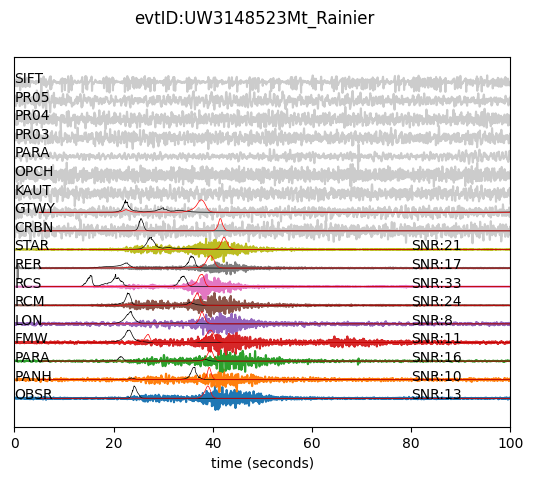

3148653 2021-01-07T13:38:46.000000Z
Mt_Rainier
The approximate duration of this event is 70.750000 s 
Window data shape: (11, 3, 6401)


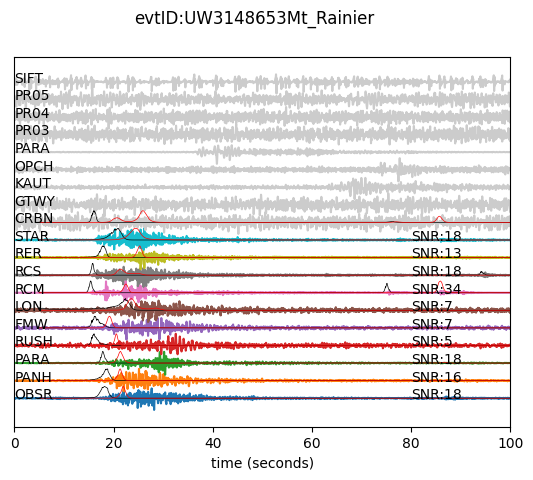

3148658 2021-01-07T14:48:22.000000Z
Mt_Rainier
The approximate duration of this event is 70.225000 s 
Window data shape: (9, 3, 6401)


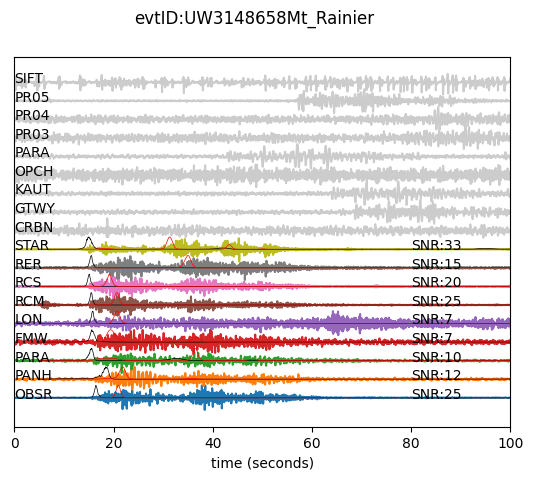

3148723 2021-01-09T10:20:52.000000Z
Mt_Rainier
The approximate duration of this event is 77.575000 s 
Window data shape: (14, 3, 6401)


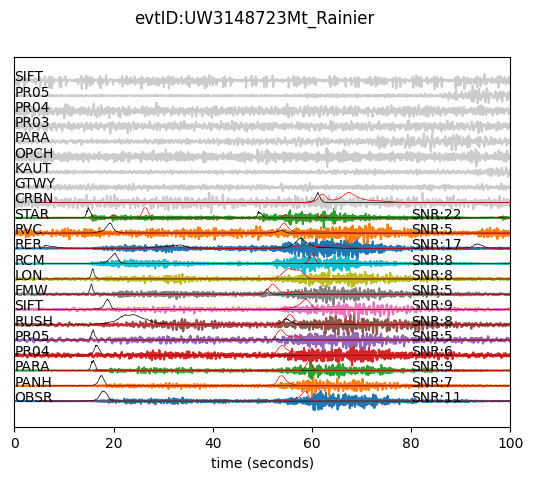

3148888 2021-01-13T05:32:09.000000Z
Mt_Rainier
The approximate duration of this event is 25.375000 s 
Window data shape: (13, 3, 6401)


/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_5996/131562081.py:234: RuntimeWarning: divide by zero encountered in divide
  data_max = crap2 / (np.max(np.abs(crap2), axis=-1, keepdims=True))


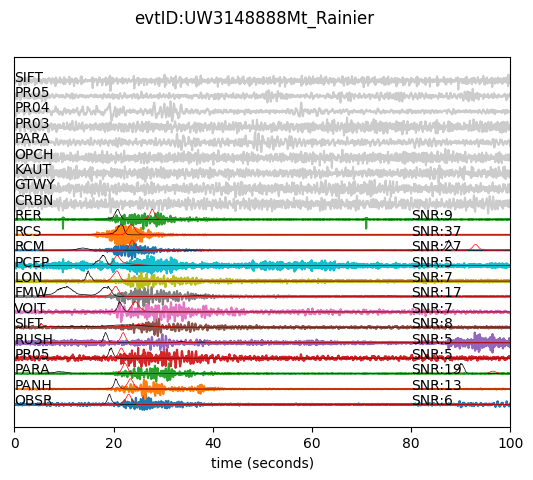

3148893 2021-01-13T05:37:40.000000Z
Mt_Rainier
The approximate duration of this event is 37.725000 s 
Window data shape: (18, 3, 6401)


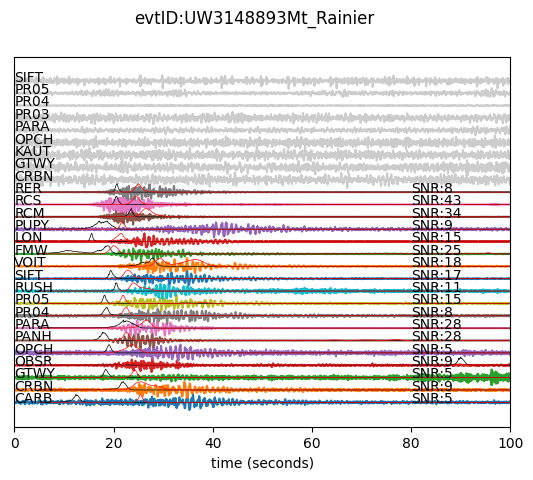

3148963 2021-01-14T12:21:39.000000Z
Mt_Rainier
The approximate duration of this event is 106.000000 s 
Window data shape: (9, 3, 6401)


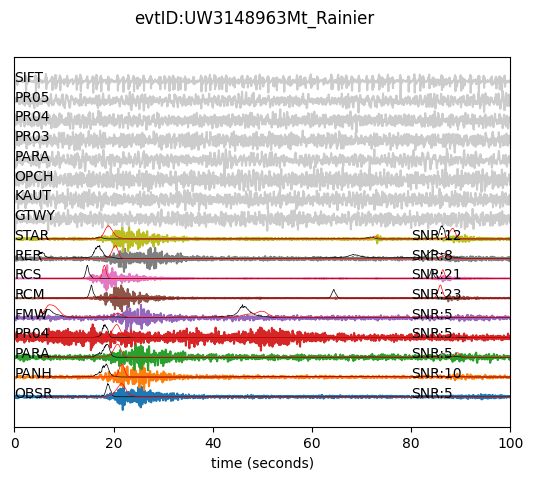

3149803 2021-01-15T23:31:03.000000Z
Mt_Rainier
The approximate duration of this event is 48.225000 s 
Window data shape: (15, 3, 6401)


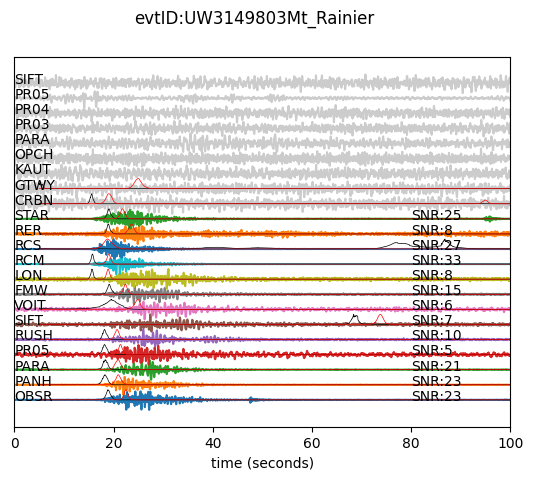

3149813 2021-01-16T19:32:28.000000Z
Mt_Rainier
The approximate duration of this event is 107.900000 s 
Window data shape: (6, 3, 6401)


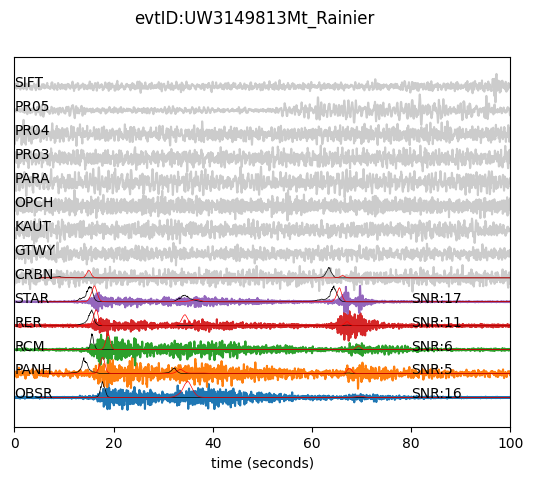

3149818 2021-01-17T00:16:54.000000Z
Mt_Rainier
The approximate duration of this event is 74.050000 s 
Window data shape: (15, 3, 6401)


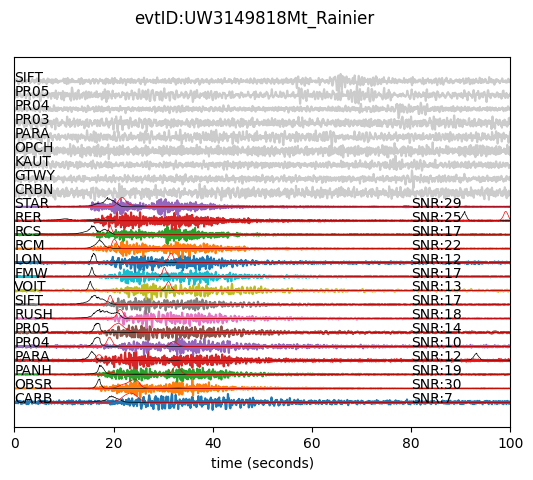

3149823 2021-01-17T01:33:16.000000Z
Mt_Rainier
The approximate duration of this event is 51.425000 s 
Window data shape: (17, 3, 6401)


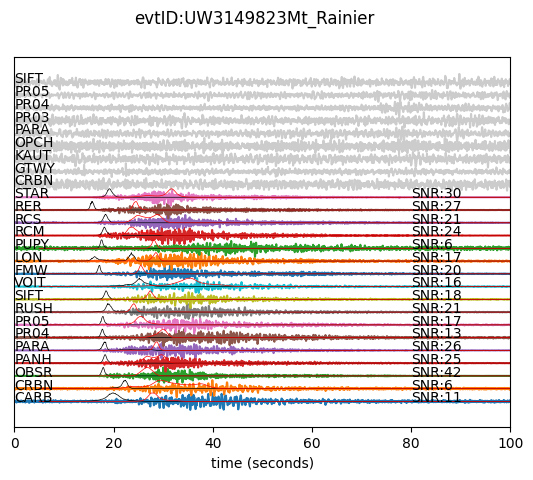

3151273 2021-01-17T12:15:55.000000Z
Mt_Rainier
The approximate duration of this event is 59.800000 s 
Window data shape: (14, 3, 6401)


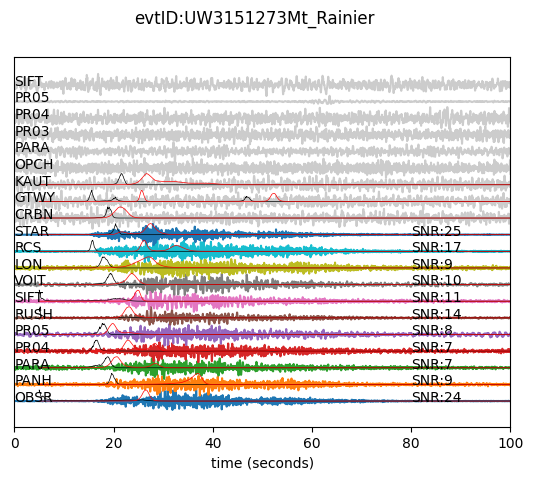

3149718 2021-01-19T10:13:47.000000Z
Mt_Rainier


TimeoutError: timed out

In [32]:

for n in range(11649,len(evt_id)): 
    if start_time[n]<datetime(2021,1,1):continue   
    event_ID = str(evt_id[n])
    otime = UTCDateTime(start_time[n])
    print(event_ID,otime)
    if net != 'CN' and evt_id[n]!=evt_id[n-1]:
        reference = str(net[n]+'.'+sta[n])
        try:
            associated_volcano = df[df['Station']== sta[n]]['Volcano_Name'].values[0]
        except: 
            pass
        print(associated_volcano)
        if associated_volcano!="Mt_Rainier":continue
            
        #get info for stations within 50km of volcano that event ocurred at
        stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
        networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
        latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
        longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
        elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()

        if stations.count("LON")>0 and stations.count("LO2")>0:
            index = stations.index("LO2")
            del stations[index]
            del networks[index]
            del latitudes[index]
            del longitudes[index]
            del elevations[index]


#################### WAVEFORM DOWNLOAD #######################
        #Download all waveforms for that event based on stations and times
        bulk = [] 
        for m in range(0, len(networks)):
            bulk.append([networks[m], stations[m], '*', '*H*', otime-t_before_raw, otime+t_after_raw])
        st = client2.get_waveforms_bulk(bulk)


        bulk2 = [] 
        for m in range(0, len(networks)):
            bulk2.append([networks[m], stations[m], '01', 'BDF', otime-t_before_raw, otime+t_after_raw])
        infra = client2.get_waveforms_bulk(bulk2)
        #remove unwanted data
        for tr in st:
            cha = tr.stats.channel
            try:
                if len(tr.data)/tr.stats.sampling_rate < 239.9:
                    st.remove(tr)
            except:
                pass

        #resampling the data to 40Hz for each trace
        st = resample(st,fs) 
        infra = resample(infra,fs) 
        # #Plotting all traces for one event with channel z, SNR>10, and bandpasses between 2-12Hz
        SNR,SNR_weight, no_weight,stas,nets,max_amp_times,durations,data_env_dict,t_diff = [],[],[],[],[],[],[],{},{}
        fig = plt.figure()#figsize = (11,8), dpi=200)
        fig.suptitle('evtID:UW'+ event_ID+associated_volcano)
        evt_data = obspy.Stream()
        # plt.rcParams.update({'font.size': 20})
        ax = plt.subplot(1,1,1)
        iplot = 0
        # zz = evt_data.select(component="Z")
        for i,ii in enumerate(st):
            network = ii.stats.network
            station = ii.stats.station
            ii.detrend(type = 'demean')
            ii.filter('bandpass',freqmin=low_cut,freqmax=high_cut,corners=2,zerophase=True)
            cha = ii.stats.channel
            # ii.trim(otime,otime+window)
            starttime = ii.stats.starttime
            signal_window = ii.copy()
            noise_window = ii.copy()
            signal_window.trim(otime - 15, otime - 15 + window) # trim the signal at the first pick time of the PNSN data, with loose 40s before
            noise_window.trim(otime - window -15, otime - 15) # noise window of the same length
            if not len(signal_window.data) or not len(signal_window.data): continue
            # print(len(signal_window),len(noise_window.data))
            snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                            / np.percentile(np.abs(noise_window.data),pr))/np.log(10))
            max_amp_time = np.argmax(noise_window.data)/fs
            # print(snr,max_amp_time)
            # signal_window.plot()x
            if snr<thr: # and 100<max_amp_time<200:
                st.remove(ii)
                continue
            t = signal_window.times()
            t_diff[network+'.'+station] = starttime-otime 
            # enveloping the data 
            data_envelope = obspy.signal.filter.envelope(signal_window.data)
            data_envelope /= np.max(data_envelope)
            # data_envelope += iplot*1.5
            # finding the time of max amplitude of each event
            max_amp_times.append(max_amp_time)
            max_amp = np.max(ii.data)      
            # creating envelope data dictionary to calculate picktimes
            data_envelope = obspy.signal.util.smooth(data_envelope, smooth_length)
            # kurt = rt.signal.kurtosis(signal_window.taper(max_percentage=0.05))
            # kurt /= np.max(kurt)
            data_env_dict[network+'.'+station]= data_envelope
            # b,e = 115,150
            if cha[-1]=="Z":
                ax.plot(t,signal_window.data/np.max(np.abs(signal_window.data))+iplot*1.5)
                # ax.plot(t,data_envelope+iplot*1.5, color = 'k')
                # ax1.plot(t,kurt+iplot*1.5, color = 'r')
                # ax1.plot(t[(t_before_raw+b)*fs:(t_before_raw+e)*fs], data_envelope, color = 'k')
                # ax1.plot(t[b*fs:e*fs],ii.data[b*fs:e*fs]/np.max(np.abs(ii.data))+iplot*1.5)
                # ax1.plot(t[115*fs:150*fs], data_envelope, color = 'k')
                ax.set_xlabel('time (seconds)')
                # ax1.set_xlim([b+t_before_raw,e+t_before_raw])
                ax.set_yticks([])
                plt.text(80, iplot*1.5, 'SNR:'+str(int(snr)))
                plt.text(0, iplot*1.5, station)

                iplot += 1
            stas.append(ii.stats.station)
            nets.append(ii.stats.network)
            SNR.append(snr)
            SNR_weight.append(int(snr))
            no_weight.append(1)
            evt_data.append(signal_window)

#       Plot the infrasound as well

        for i,ii in enumerate(infra):
            ii.filter('bandpass',freqmin=1,freqmax=10,corners=2,zerophase=True)
            signal_window = ii.copy()
            signal_window.trim(otime - 15, otime - 15  + window) # trim the signal at the first pick time of the PNSN data, with loose 40s before
            if not len(signal_window.data): continue
            t1 = signal_window.times()
            ax.plot(t1,signal_window.data/np.max(np.abs(signal_window.data))+iplot*1.5,color='0.8')
            ax.text(0, iplot*1.5, signal_window.stats.station)
            iplot+=1
        ax.set_xlim((0,100))
    # impose at least 4 stations
    if len(evt_data)<4:  
        continue

    sta_available = np.unique(np.array(stas))
    

## Get an approximative measurement of duration taking the highest SNR data
    ik=np.argmax(SNR)
    crap =np.cumsum(np.abs(evt_data[ik].data))
    maxcrap = crap[-1]
    Td=len(np.where((crap>=0.02*crap[-1])&(crap<=0.95*crap[-1]))[0])/fs
    print("The approximate duration of this event is %f s "%Td)



############## PEAK FREQUENCY MEASUREMENTS ############
# Given the approximate measurement of duration, window the signal windows around that
# then measure peak frequency so that there is less noise in it.
# perform this on the Z component only.
    data2measure_peak_frequency=evt_data.copy()
    data2measure_peak_frequency=data2measure_peak_frequency.select(component="Z")
    data2measure_peak_frequency.taper(max_percentage=0.01,max_length=20)
    batch_pred = np.zeros([2, len(data2measure_peak_frequency), 6001], dtype = np.float32)

    # evt_data.trim(starttime=otime-20,endtime=otime+Td+20) 
    #         # make plot of spectra
    char_freq, sharp_weight= [],[]
    # fig1,ax1 = plt.subplots(1,1,figsize=(11,7), dpi = 200)
    for i in range(len(data2measure_peak_frequency)):
        data = data2measure_peak_frequency[i].data #*100
        f,psd=scipy.signal.welch(data,fs=fs,nperseg=81,noverlap=4)
        #just get the frequencies within the filter band
        above_low_cut = [f>low_cut]
        below_high_cut = [f<high_cut]
        in_band = np.logical_and(above_low_cut,below_high_cut)[0]
        f = f[in_band]
        psd = psd[in_band]

        # calculate characteristic frequency and report
        char_freq_max = f[np.argmax(psd)]
        char_freq_mean= np.sum(psd*f)/np.sum(psd)
        psd_cumsum = np.cumsum(psd)
        psd_sum = np.sum(psd)
        char_freq_median = f[np.argmin(np.abs(psd_cumsum-psd_sum/2))]
        char_freq.append(char_freq_mean)

#             plt.rcParams.update({'font.size': 20})
        # ax1.plot(f,psd,label=stas[i],linewidth=2)
        # ax1.set_xscale('log')
        # ax1.set_yscale('log')
        # ax1.grid('True')
        # ax1.set_xlabel('Frequency [Hz]')
        # ax1.set_ylabel('PSD [$(mm/s)^2$/Hz]')
        # ax1.vlines(char_freq_mean,ymin=np.min(psd)/10,ymax=np.max(psd)*10,linestyle="--",colors=colors[i])

#             # weighting the data by the spikiness of the PSD vs frequency graphs
        ratio = (np.mean(psd)/np.max(psd))
        sharp_weight.append(int(1/(ratio**2)*20))

#         ax.legend() 
        # plt.savefig('../plots/psd'+event_ID+associated_volcano+'.png')

        # lats, lons, elevs, r, theta = ([] for i in range(5)) 
        # ref = str(nets[0]+'.'+stas[0])
        # try:
        #     ref_env = data_env_dict[reference]
        # except:
        #     ref_env = data_env_dict[ref]
    # del fig1
    ################### PHASE PICKING using retrained eqT ####################
    # 1. Data Prep: 1) gather all stream into (n,3,6000) , 2) sort channel to ZEN, 3) normalize data
    

    bigS = np.zeros(shape=(len(sta_available),3,6401))
    stas=[]
    for i in range(len(sta_available)):
        stream = evt_data.select(station=sta_available[i])
        # print("original stream")
        # print(stream)
        if len(stream)<3:
            # copy stream to 2 components, zero the missing data.
            tr3 = stream[0].copy() # assumed to be the vertical
            tr2 = stream[0].copy();tr2.stats.channel=stream[0].stats.channel[0:2]+"N"
            tr1 = stream[0].copy();tr1.stats.channel=stream[0].stats.channel[0:2]+"E"
            tr1.data=np.zeros(len(stream[0].data))
            tr2.data=np.zeros(len(stream[0].data))
            stream=obspy.Stream(traces=[tr1,tr2,tr3])
        # convert Stream into seisbench-friendly array    
        # fill in big array and order data ZNE
        bigS[i,0,:]=stream[2].data
        bigS[i,1,:]=stream[1].data
        bigS[i,2,:]=stream[0].data
        stas.append(sta_available[i])
    # pre process the data
    crap2  = bigS.copy()
    crap2 -= np.mean(crap2,axis=-1,keepdims=True) # demean data
    # original use std norm
    data_std = crap2 / np.std(crap2) + 1e-10
    # could use max data
    data_max = crap2 / (np.max(np.abs(crap2), axis=-1, keepdims=True))


    # taper the data
    tap = 0.5 * (1 + np.cos(np.linspace(np.pi, 2 * np.pi, 6)))
    data_std[:, :, :6] *= tap; data_std[:,:, -6:] *= tap[::-1]; 
    data_max[:,:, :6] *= tap; data_max[:,:, -6:] *= tap[::-1]
    print(f"Window data shape: {data_std.shape}")

    data_std_trim = data_std[:, :,200 :-201]
    data_max_trim = data_max[:, :,200 :-201]

    eqt.eval()
    windows_max_tt = torch.Tensor(data_std_trim)
    _torch_pred = eqt(windows_max_tt.to(device))
    batch_pred =np.zeros(shape=(data_std.shape[0],2,6000))
    batch_pred[:,0, :] = _torch_pred[1].detach().cpu().numpy()[:, :]
    batch_pred[:,1, :] = _torch_pred[2].detach().cpu().numpy()[:, :]
    iplot=0
    for i in range(len(stas)):
        crap = batch_pred[i, 0, :]
        # crap2 = batch_pred[i, 1, :]
        ax.plot(t[200:-201],crap/np.max(np.abs(crap))+iplot*1.5,'k',linewidth=0.5)
        # ax.plot(t[200:-201],crap2/np.max(np.abs(crap2))+iplot*1.5,'r',linewidth=0.5)
        iplot+=1


    ax.plot()
    fig.savefig('../plots/waveforms_'+event_ID+associated_volcano+'_picks.png')
    # del fig 
    # break


    plt.show()


## Now try Picking with envelopes

In [ ]:
for n in range(6290,6291):    
    event_ID = str(evt_id[n])
    time = UTCDateTime(start_time[n])
    if net != 'CN' and evt_id[n]!=evt_id[n-1]:
        reference = str(net[n]+'.'+sta[n])
        try:
            associated_volcano = df[df['Station']== sta[n]]['Volcano_Name'].values[0]
        except: 
            pass
        print(associated_volcano)
        # if associated_volcano == 'Mt_Rainier':
            
        #get info for stations within 50km of volcano that event ocurred at
        stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
        networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
        latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
        longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
        elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()

        if stations.count("LON")>0 and stations.count("LO2")>0:
            index = stations.index("LO2")
            del stations[index]
            del networks[index]
            del latitudes[index]
            del longitudes[index]
            del elevations[index]

            #Download all waveforms for that event based on stations and times
            bulk = [] 
            for m in range(0, len(networks)):
                bulk.append([networks[m], stations[m], '*', '*', time-t_before, time+t_after])
            st = client2.get_waveforms_bulk(bulk)

            #remove unwanted data
            for tr in st:
                cha = tr.stats.channel
                if cha[0:2] != 'BH' and cha[0:2] != 'EH' and cha[0:2] != 'HH':
                    st.remove(tr)
                try:
                    if len(tr.data)/tr.stats.sampling_rate < 239.9:
                        st.remove(tr)
                except:
                    pass

            #resampling the data to 40Hz for each trace
            st = resample(st,fs) 

            #Plotting all traces for one event with channel z, SNR>10, and bandpasses between 2-12Hz
            SNR,SNR_weight, no_weight,stas,nets,max_amp_times,durations,data_env_dict,t_diff = [],[],[],[],[],[],[],{},{}
            fig = plt.figure(figsize = (11,8), dpi=200)
            fig.suptitle('evtID:UW'+ event_ID+associated_volcano)
            plt.rcParams.update({'font.size': 20})
            ax1 = plt.subplot(1,1,1)
            iplot = 0
            for i,ii in enumerate(st):
                network = ii.stats.network
                station = ii.stats.station
                ii.detrend(type = 'demean')
                ii.filter('bandpass',freqmin=2.0,freqmax=12.0,corners=2,zerophase=True)
                cha = ii.stats.channel
                starttime = ii.stats.starttime
                max_amp_time = np.argmax(ii.data)/fs
                signal_window = ii.copy()
                noise_window = ii.copy()
                signal_window.trim(starttime + t_before - 20, starttime + t_before - 20 + window)
                noise_window.trim(starttime + t_before - window -10, starttime + t_before - 10)
                snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                               / np.percentile(np.abs(noise_window.data),pr))/np.log(10))

                if cha[-1] == 'Z' and snr>thr and 100<max_amp_time<200:
                    t = ii.times()
                    t_diff[network+'.'+station] = starttime-time 
                    # enveloping the data 
                    data_envelope = obspy.signal.filter.envelope(ii.data[115*fs:150*fs])
                    data_envelope /= np.max(data_envelope)
                    data_envelope += iplot*1.5
                    # finding the time of max amplitude of each event
                    max_amp_times.append(max_amp_time)
                    max_amp = np.max(ii.data)      
                    # creating envelope data dictionary to calculate picktimes
                    data_envelope = obspy.signal.util.smooth(data_envelope, smooth_length)
                    data_env_dict[network+'.'+station]= data_envelope
                    b,e = 115,150
                    ax1.plot(t[b*fs:e*fs],ii.data[b*fs:e*fs]/np.max(np.abs(ii.data))+iplot*1.5)
                    ax1.plot(t[115*fs:150*fs], data_envelope, color = 'k')
                    ax1.set_xlabel('time (seconds)')
                    ax1.set_xlim([b,e])
                    ax1.set_yticks([])
                    plt.text(t[e*fs], iplot*1.5, 'SNR:'+str(int(snr)))
                    plt.text(t[b*fs], iplot*1.5, station)
                    iplot = iplot+1
                    stas.append(ii.stats.station)
                    nets.append(ii.stats.network)
                    SNR.append(snr)
                    SNR_weight.append(int(snr))
                    no_weight.append(1)
                else:
                    st.remove(ii)

            if len(st)<4:  
                continue

            # get peak frequency of each event
            # read and preprocess data
            st.taper(max_percentage=0.01,max_length=20)
            st.trim(starttime=time-20,endtime=time+30) 

            # make plot of spectra
            char_freq, sharp_weight= [],[]
    #         fig,ax = plt.subplots(1,1,figsize=(11,7), dpi = 200)
            for i in range(len(stas)):
                data = st.select(station=stas[i],component="Z")[0].data*100
                f,psd=scipy.signal.welch(data,fs=st[0].stats.sampling_rate,nperseg=81,noverlap=1)
                #just get the frequencies within the filter band
                above_low_cut = [f>low_cut]
                below_high_cut = [f<high_cut]
                in_band = np.logical_and(above_low_cut,below_high_cut)[0]
                f = f[in_band]
                psd = psd[in_band]

                # calculate characteristic frequency and report
                char_freq_max = f[np.argmax(psd)]
                char_freq_mean= np.sum(psd*f)/np.sum(psd)
                psd_cumsum = np.cumsum(psd)
                psd_sum = np.sum(psd)
                char_freq_median = f[np.argmin(np.abs(psd_cumsum-psd_sum/2))]
                char_freq.append(char_freq_mean)

                plt.rcParams.update({'font.size': 20})
    #             ax.plot(f,psd,label=stas[i],linewidth=2)
    #             ax.set_xscale('log')
    #             ax.set_yscale('log')
    #             ax.grid('True')
    #             ax.set_xlabel('Frequency [Hz]')
    #             ax.set_ylabel('PSD [$(mm/s)^2$/Hz]')
    #             ax.vlines(char_freq_mean,ymin=np.min(psd)/10,ymax=np.max(psd)*10,linestyle="--",colors=colors[i])

                # weighting the data by the spikiness of the PSD vs frequency graphs
                ratio = (np.mean(psd)/np.max(psd))
                sharp_weight.append(int(1/(ratio**2)*20))

    #         ax.legend() 
    #         plt.savefig('psd'+event_ID+associated_volcano+'.png')

            lats, lons, elevs, r, theta = ([] for i in range(5)) 
            ref = str(nets[0]+'.'+stas[0])
            try:
                ref_env = data_env_dict[reference]
            except:
                ref_env = data_env_dict[ref]

            ############ PHASE PICKING ############################
            # calculating the picktimes and shift in arrival times using envelope cross_correlation
            pick_times, offsets, starttimes = pick_time(time, ref_env, data_env_dict,st,t_diff, t_before, fs) #calculate picktimes
            shifts, vals = shift(pick_times, offsets, starttimes, t_diff)

            iplot = 0 
            durations = []
            for i in range(len(stas)):
                max_amp_time = max_amp_times[i]
                duration = (max_amp_time-vals[i])*2
                durations.append(duration)
                ax1.vlines(vals[i], ymin = iplot*1.5-.5, ymax = iplot*1.5+.5, color = colors[i])
                #plt.text(t[110*fs], iplot*1.5, 'duration:'+str(int(duration))+'s')
                a = stations.index(stas[i])
                lats.append(latitudes[a])
                lons.append(longitudes[a])
                elevs.append(elevations[a])
                iplot = iplot+1
            avg_duration = np.mean(durations)
            plt.savefig('wiggles'+event_ID+associated_volcano+'.png')



            ############ LOCATION ############################
            # input necessary data for grid search
            arrivals = shifts
            sta_lats = lats
            sta_lons= lons

            # define grid origin in lat,lon and grid dimensions in m
            lat_start = volc_grid[associated_volcano][0]
            lon_start = volc_grid[associated_volcano][1]
            side_length = volc_grid[associated_volcano][2]

            # create the grid of locations
            sta_x = []
            sta_y = []
            for i in range(len(sta_lats)):
                x_dist = distance.distance([lat_start,lon_start],[lat_start,sta_lons[i]]).m
                y_dist = distance.distance([lat_start,lon_start],[sta_lats[i],lon_start]).m
                sta_x.append(x_dist)
                sta_y.append(y_dist)
            x_vect = np.arange(0, side_length, step)
            y_vect = np.arange(0, side_length, step)
            t0 = np.arange(0,np.max(arrivals),t_step)

            # carry out the gridsearch weighted by SNR
            weight = np.array(SNR_weight)/np.max(SNR_weight)
            rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
            loc_idx_snr = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)

            # gridsearch with no weight
            weight = [1 for i in range(len(SNR_weight))]
            rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
            loc_idx = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)

            # gridsearch weighted with SNR and Slope
            # plot DEM
            # gives the lower left grid point in the grid search
            # gives the left right, bottom, top of the grid
            left, right = r_dem_data_dict[associated_volcano]['left'],r_dem_data_dict[associated_volcano]['right']
            bottom, top = r_dem_data_dict[associated_volcano]['bottom'],r_dem_data_dict[associated_volcano]['top']

            crs = dem_data_dict[associated_volcano]['crs']
            data = dem_data_dict[associated_volcano]['data']
            volc = rd.rdarray(data, no_data=-9999)
            slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
            info = volc_lat_lon[associated_volcano]
            p2 = Proj(crs,preserve_units=False)
            p1 = Proj(proj='latlong',preserve_units=False)
            # gives the lower left grid point in the grid search
            left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
            # gives the left right, bottom, top of the grid
            grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
            left, right = r_dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
            bottom, top = r_dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']

            a = int((left_x-left)/10)
            b = a+2500
            c = (slope.shape[0] - int((bottom_y-bottom)/10))-2500
            d = slope.shape[0] - int((bottom_y-bottom)/10)

            x = np.arange(a,b,1)
            y = np.arange(c,d,1)

            x2 = np.arange(a,b,10) # every 100m
            y2 = np.arange(c,d,10) # every 100m

            slope_data = np.array(slope[c:d,a:b])


            slope_norm1 = slope_data/np.max(slope_data)

            slope_interp_mat = RectBivariateSpline(y,x,slope_norm1, s = 0)
            interp = slope_interp_mat(x2,y2)/np.max(slope_interp_mat(x2,y2))*0.9+.1

            rss_mat_slope = np.multiply(rss_mat[loc_idx[0],:,:],interp)
            loc_idx_slope = np.unravel_index([np.argmin(rss_mat_slope)], rss_mat_slope.shape)
            loc_lat_slope, loc_lon_slope, test_d = location(x_vect[loc_idx_slope[1]], y_vect[loc_idx_slope[2]], lat_start, lon_start)

            # plot heatmap
    #         fig,ax = plt.subplots(1,1,figsize=(8,8), dpi = 200)
    #         ax.scatter(x_vect[loc_idx[1]],y_vect[loc_idx[2]],s=100,marker='*',c='r')
    #         im = ax.imshow(np.log10(rss_mat[loc_idx[0],:,:].T),origin="lower",extent=[0,side_length,0,side_length])
    #         ax.set_ylabel('(m)')
    #         ax.set_ylabel('(m)')
    #         cbar = plt.colorbar(im)
    #         cbar.ax.tick_params()
    #         cbar.set_label('RMS error on location', rotation=270)
    #         plt.savefig('heatmap'+ event_ID+associated_volcano+'.png')


            # find the latitude and longitude of the location index
            loc_lat, loc_lon, d = location(x_vect[loc_idx[1]], y_vect[loc_idx[2]], lat_start, lon_start)
            err_thr = np.min(np.log10(rss_mat))+.05
            thr_array = np.argwhere(np.log10(rss_mat)<err_thr)
            diameter = error_diameter(thr_array)

            break
            # calculating azimuth for each station with respect to the middle of the volcano
            for i in range(len(stas)):
                u,b,c = (gps2dist_azimuth(loc_lat, loc_lon, lats[i], lons[i], a=6378137.0, f=0.0033528106647474805))
                r.append(u)
                theta.append(b)

            bin1,bin2,bin3 = [],[],[]
            for i in theta:
                if 0<=i<=120:
                    bin1.append(i)
                if 121<=i<=240:
                    bin2.append(i)
                if 241<=i<=360:
                    bin3.append(i)

            if bin1 == [] or bin2 == [] or bin3 == []:
                continue

            #manipulating the data
            data = {'azimuth_deg':theta, 'freq':char_freq, 'station':stas, 'distance_m':r, 
                    'weight':sharp_weight, 'SNR':SNR, 'colors':colors[0:len(stas)]}
            DF = pd.DataFrame(data, index = None)
            DF2 = DF.sort_values('azimuth_deg')

            #Taking out stations that are too close to the location when looking at azimuth 
            drops = []
            for i in range(len(DF2)):
                value = DF2.loc[i,'distance_m']
                if value < az_thr:
                    drops.append(i)
            DF3 = DF2.drop(drops)
            y_data =  DF3["freq"].values.tolist()
            Sta2 = DF3["station"].values.tolist()
            dist2 = DF3["distance_m"].values.tolist()
            spike_weight = DF3["weight"].values.tolist()
            SNR2 = DF3['SNR'].values.tolist()
            colors2 = DF3['colors'].values.tolist()
            x_data =  np.asarray(DF3["azimuth_deg"].values.tolist())
            x_points = np.linspace(0,360, 100)


            ################ DIRECTIVITY FIT ##################################
            #optimizing parameters to fit data to test_function
            params, params_covariance = optimize.curve_fit(test_func, np.deg2rad(x_data), y_data, p0=None)
            perr = np.sqrt(np.diag(params_covariance))
            std_deviation = str(round(perr[0],9))+','+str(round(perr[1],9))+','+str(round(perr[2],9))
            d = test_func(np.deg2rad(x_points), params[0], params[1], params[2])
            len_r = int(max(r))

            if params[0]<0:
                direction = params[1]+pi 
            else:
                direction = params[1]

            fmax = max(d)
            fmin = min(d)
            v = v_s*((fmax-fmin)/(fmax+fmin))



            # weight the data
            # title = 'Sharpness'
            v_sharp,direction_sharp,d_sharp = weight_data(x_data,y_data,sharp_weight,test_func,v_s,stas)

            # title = 'SNR'
            v_snr,direction_snr,d_snr = weight_data(x_data,y_data,SNR_weight,test_func,v_s,stas)  




            ############### PLOTS ###################
            #convert the direction from polar to cartesian coordinates
            dy = len_r*np.sin(direction)
            dx = len_r*np.cos(direction)     

            dy_sharp = len_r*np.sin(direction_sharp)
            dx_sharp = len_r*np.cos(direction_sharp)    


            dy_snr = len_r*np.sin(direction_snr)
            dx_snr = len_r*np.cos(direction_snr) 




            fig,ax = plt.subplots(1,1,figsize=(11,8), dpi = 200)
            fig.suptitle('Fitted Cosine Curves')       
            ax.set_ylabel('characteristic frequency(Hz)')
            ax.set_xlabel(('azimuth(degrees)'))
            for i in range (0,len(Sta2)):
                ax.scatter(x_data[i], y_data[i], s = (SNR_weight[i]**2),label=Sta2[i], color = colors2[i])
            ax.plot(x_data,y_data, '--', label='rawdata')
            ax.plot(x_points, d, label = 'original')
            ax.plot(x_points, d_sharp, label = 'sharpness')
            ax.plot(x_points, d_snr, label = 'snr')
            ax.legend(loc='upper right', fontsize = 10)
            plt.grid(True)
            plt.savefig('curves_freq_data'+ event_ID+associated_volcano+'.png')

            #making plots of directivity and location
            crs = dem_data_dict[associated_volcano]['crs']
            data = dem_data_dict[associated_volcano]['data']
            info = volc_lat_lon[associated_volcano]
            p2 = Proj(crs,preserve_units=False)
            p1 = Proj(proj='latlong',preserve_units=False)
            # gives the lower left grid point in the grid search
            left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
            # gives the left right, bottom, top of the grid
            grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
            left, right = dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
            bottom, top = dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']

            # convert loc data onto the DEM data
            contour_x,contour_y = np.meshgrid(left_x+x_vect,bottom_y+y_vect)
            center_x, center_y = transform(p1,p2,info[1],info[0])
            loc_x,loc_y=transform(p1,p2,loc_lon,loc_lat)
            duration=avg_duration
            length_factor = duration/100

            fig,ax = plt.subplots(1,1,figsize=(8,11), dpi = 200)
            a = ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth')
            contours = ax.contour(contour_x,contour_y,np.log10(rss_mat[int(loc_idx[0]),:,:].T),cmap='plasma')
            ax.scatter(center_x, center_y, s=100,marker='*',c='r')
            plt.arrow(loc_x,loc_y,dy*length_factor,dx*length_factor, color='w', width=170, label='no weight')
            plt.arrow(loc_x,loc_y,dy_sharp*length_factor,dx_sharp*length_factor, color='k', width=170, label='sharpness')
            plt.arrow(loc_x,loc_y,dy_snr*length_factor,dx_snr*length_factor, color='m', width=170, label='snr')
            #plotting the stations on top of this as triangles
            for i, ii in enumerate(stas):
                sta_x,sta_y = transform(p1,p2,lons[i],lats[i])
                if left+info[3]<sta_x<right-info[4] and bottom+info[5]<sta_y<top-info[6]:
                    ax.plot(sta_x,sta_y, c='k', marker="^")
                    ax.text(sta_x,sta_y,ii, c='k', fontsize = 15)

            #getting lat and lon tick marks on the axis
            tick_lons = lat_lon_dict[associated_volcano]['tick_lons']
            tick_lats = lat_lon_dict[associated_volcano]['tick_lats']
            ticks_x = []
            ticks_y = []
            for i in range(len(tick_lons)):
                tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])
                ticks_x.append(tick_x)
                ticks_y.append(tick_y)
                tick_lons[i]=str(tick_lons[i])
                tick_lats[i]=str(tick_lats[i])
            divider = make_axes_locatable(ax)
            cax1 = divider.append_axes('right', size='4%', pad=0.1)
            cax2 = divider.append_axes('right', size='4%', pad=1.3)
            ax.set_title('Location and Directivity', fontsize = 20)
            ax.set_xlabel('longitudes(DD)', fontsize = 15)
            ax.set_ylabel('latitudes(DD)', fontsize = 15)
            ax.set_xticks(ticks_x)
            ax.set_xticklabels(tick_lons, fontsize = 15)
            ax.set_yticks(ticks_y)
            ax.set_yticklabels(tick_lats, fontsize = 15)
            ax.clabel(contours)
            cbar = plt.colorbar(a, cax=cax1)
            cbar.ax.tick_params(labelsize=10)
            cbar.set_label('elevation(m)\n', rotation=270, labelpad = 13, fontsize = 15)
            cbar2 = plt.colorbar(contours, cax=cax2)
            cbar2.ax.tick_params(labelsize=10)
            cbar2.set_label('RMS error on location\n', rotation=270, labelpad = 13,fontsize = 15)
            ax.set_xlim(left+info[3],right-info[4])
            ax.set_ylim(bottom+info[5],top-info[6])
            ax.legend(fontsize = 12)
            plt.tight_layout()
            plt.savefig('loc_direction'+ event_ID+associated_volcano+'.png',bbox_inches="tight")

            # make a dataframe of the data
            evt_data = evt_data.append({'event_ID':event_ID, 
                        'location_latitude': loc_lat,
                        'location_longitude': loc_lon,
                        'location_uncertainty(m)':diameter/10,
                        'origin_time': min(offsets)-int(loc_idx[0]),
                        'direction(degrees)':np.rad2deg(direction),
                        'direction_sharpness(degrees)':np.rad2deg(direction_sharp),
                        'direction_snr(degrees)':np.rad2deg(direction_snr),
                        'duration(sec)':avg_duration,
                        'params_std_deviation':std_deviation, 
                        'velocity(m/s)':v, 
                        'number_of_stations':len(stas)}, ignore_index = True)

            dict_temp = {}
            for i in range(len(stas)):
                dict_temp[stas[i]] = char_freq[i]
            print(dict_temp)    
            sta_freq = sta_freq.append(dict_temp,ignore_index = True)

            evt_data.to_csv('~/surface_events/Event_Data.csv', index=False)
            sta_freq.to_csv('~/surface_events/Station_frequency_data.csv', index=False)
    #     except:
    #         reject_evts = reject_evts.append({'event_ID':[event_ID]}, ignore_index = True)
    #         reject_evts.to_csv('~/surface_events/Rejects5.csv', index=False)
    #         continue


In [ ]:
#DEM data 
r_dem_data_dict = {}
name = 'Mt_Rainier'
if volc_lat_lon[name][0]>46:
    dem = rio.open('Data/DEM_data/'+str(name)+'/'+str(name)+'1.tif') #washington volcanoes
    dem_array = dem.read(1).astype('float64')
    dem_array[dem_array == -32767] = np.nan #gets rid of edge effects
    crs = dem.crs

r_dem_data_dict[name]={'data':dem_array, 'crs':crs, 'left':dem.bounds[0], 'right':dem.bounds[2], 'bottom':dem.bounds[1], 'top':dem.bounds[3]}

In [ ]:
# Determine the avg slope value within one step of the grid search model
associated_volcano = 'Mt_Rainier'
step_gs = 100 # grid search model step size is 100m

# plot DEM
crs = r_dem_data_dict[associated_volcano]['crs']
data = r_dem_data_dict[associated_volcano]['data']
volc = rd.rdarray(data, no_data=-9999)
slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
info = volc_lat_lon[associated_volcano]
p2 = Proj(crs,preserve_units=False)
p1 = Proj(proj='latlong',preserve_units=False)
# gives the lower left grid point in the grid search
left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
# gives the left right, bottom, top of the grid
grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
left, right = r_dem_data_dict[associated_volcano]['left'],r_dem_data_dict[associated_volcano]['right']
bottom, top = r_dem_data_dict[associated_volcano]['bottom'],r_dem_data_dict[associated_volcano]['top']
contour_x,contour_y = np.meshgrid(left_x+x_vect,bottom_y+y_vect)
center_x, center_y = transform(p1,p2,info[1],info[0])
loc_x,loc_y=transform(p1,p2,loc_lon,loc_lat)

# looking at where the grid is:
x = np.linspace(left_x, left_x+25000, 10)
y = np.linspace(bottom_y, bottom_y+25000, 10)

In [ ]:
a = int((left_x-left)/10)
b = a+2500
c = (slope.shape[0] - int((bottom_y-bottom)/10))-2500
d = slope.shape[0] - int((bottom_y-bottom)/10)

x = np.arange(a,b,1)
y = np.arange(c,d,1)

x2 = np.arange(a,b,10) # every 100m
y2 = np.arange(c,d,10) # every 100m

slope_data = np.array(slope[c:d,a:b])

In [ ]:
slope_norm1 = slope_data/np.max(slope_data)

slope_interp_mat = RectBivariateSpline(y,x,slope_norm1, s = 0)
interp = slope_interp_mat(x2,y2)/np.max(slope_interp_mat(x2,y2))*0.9+.1

rss_mat_slope = np.multiply(rss_mat[loc_idx[0],:,:],interp)
loc_idx_slope = np.unravel_index([np.argmin(rss_mat_slope)], rss_mat_slope.shape)
loc_lat_slope, loc_lon_slope, j = location(x_vect[loc_idx_slope[1]], y_vect[loc_idx_slope[2]], lat_start, lon_start)


In [ ]:
plt.rcParams.update({'font.size': 5})

# weighted by SNR
weight = np.array(SNR_weight)/np.max(SNR_weight)
rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
loc_idx = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)
loc_lat, loc_lon, j = location(x_vect[loc_idx[1]], y_vect[loc_idx[2]], lat_start, lon_start)

x2 = np.linspace(a,b,250)
y2 = np.linspace(c,d,250)

# weighted by SNR and Slope
rss_mat_slope = np.multiply(rss_mat[loc_idx[0],:,:],interp)
loc_idx_slope = np.unravel_index([np.argmin(rss_mat_slope)], rss_mat_slope.shape)
loc_lat_slope, loc_lon_slope, j = location(x_vect[loc_idx_slope[1]], y_vect[loc_idx_slope[2]], lat_start, lon_start)

# unweighted
no_weight = [1,1,1,1,1,1,1,1]
rss_mat_nw = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,no_weight)
loc_idx_nw = np.unravel_index([np.argmin(rss_mat_nw)], rss_mat_nw.shape)
loc_lat_nw, loc_lon_nw, j = location(x_vect[loc_idx_nw[1]], y_vect[loc_idx_nw[2]], lat_start, lon_start)


# plotting the results
fig,ax = plt.subplots(3,1,figsize=(6,9), dpi = 180)

ax[0].set_title('weighted by SNR: '+str(round(loc_lat,3))+','+str(round(loc_lon,3)))
ax[0].scatter(x_vect[loc_idx[1]],y_vect[loc_idx[2]],s=100,marker='*',c='r')
im0 = ax[0].imshow(np.log10(rss_mat[loc_idx[0],:,:].T),origin="lower",extent=[0,side_length,0,side_length])
#im0 = ax[0].imshow(rss_mat[loc_idx[0],:,:].T,origin="lower",extent=[0,side_length,0,side_length])
ax[0].set_ylabel('(m)')
ax[0].set_ylabel('(m)')
cbar0 = plt.colorbar(im0, ax = ax[0])
cbar0.ax.tick_params()
cbar0.set_label('RMS error on location', rotation=270)

ax[1].set_title('weighted by SNR and Slope: '+str(round(loc_lat_slope,3))+','+str(round(loc_lon_slope,3)))
ax[1].scatter(x_vect[loc_idx_slope[1]],y_vect[loc_idx_slope[2]],s=100,marker='*',c='r')
im1 = ax[1].imshow(np.log10(rss_mat_slope[0,:,:].T),origin="lower",extent=[0,side_length,0,side_length])
#im1 = ax[1].imshow(rss_mat_slope[0,:,:].T,origin="lower",extent=[0,side_length,0,side_length])
ax[1].set_ylabel('(m)')
ax[1].set_ylabel('(m)')
cbar1 = plt.colorbar(im1, ax = ax[1])
cbar1.ax.tick_params()
cbar1.set_label('RMS error on location', rotation=270)

ax[2].set_title('unweighted: '+str(round(loc_lat_nw,3))+','+ str(round(loc_lon_nw,3)))
ax[2].scatter(x_vect[loc_idx_nw[1]],y_vect[loc_idx_nw[2]],s=100,marker='*',c='r')
im2 = ax[2].imshow(np.log10(rss_mat_nw[0,:,:].T),origin="lower",extent=[0,side_length,0,side_length])
#im2 = ax[2].imshow(rss_mat_nw[0,:,:].T,origin="lower",extent=[0,side_length,0,side_length])
ax[2].set_ylabel('(m)')
ax[2].set_ylabel('(m)')
cbar2 = plt.colorbar(im2, ax = ax[2])
cbar2.ax.tick_params()
cbar2.set_label('RMS error on location', rotation=270)